In [1]:
import os
import cv2
import glob
import time
import pickle
import random
import numpy as np
from skimage.feature import hog
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.ndimage.measurements import label
%matplotlib inline

In [2]:
def save_p(data, name):
    with open(name, 'wb') as f:
        pickle.dump(data, f)
def load_p(name):
    with open(name, 'rb') as f:
        data = pickle.load(f)
    return data

In [85]:
data=load_p("./data.pickle")

X=data["X"]
Y=data["Y"]
clf=data["clf"]
scaler=data["scaler"]

In [3]:
def plot_2images(img, converted, title1='Original', title2='Converted', cmap="gray", flag1=False, flag2=False):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(img)
    ax1.set_title(title1, fontsize=30)
    ax2.imshow(converted, cmap=cmap)
    ax2.set_title(title2, fontsize=30)
    
    if flag1 == True:
        mpimg.imsave("output_images/" + title1, img, format="jpg")
    if flag2 == True:
        mpimg.imsave("output_images/" + title2, converted, format="jpg")

In [4]:
def plot_image(img, title="Original", flag=False, size=(10,10), dpi=100, cmap=None):
    plt.figure(num=None, figsize=size, dpi=dpi, facecolor='w', edgecolor='k')
    if cmap != None:
        plt.imshow(img, cmap=cmap)
    else:
        plt.imshow(img)
    plt.title(title)
    
    if flag:
        mpimg.imsave("output_images/" + title, img, format="jpg")

## functions for features extraction

In [23]:
def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    return gray
    
def hsvscale(img):
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    return hsv

def hlsscale(img):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    return hls

def luvscale(img):
    luv = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    return luv

def labscale(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    return lab

def yuvscale(img):
    yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    return yuv

def gaussian_blur(img, kernel_size):
    '''gaussian smoothing'''
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [22]:
def color_space(img, flag="gray"):
    if flag=="gray":
        res=grayscale(img)
    elif flag=="hsv":
        res=hsvscale(img)
    elif flag=="hls":
        res=hlsscale(img)
    elif flag=="luv":
        res=luvscale(img)
    elif flag=="lab":
        res=labscale(img)
    elif flag=="yuv":
        res=yuvscale(img)
    return res

In [6]:
def f_hog(channel, pix_per_cell=16, cell_per_block=2, orient=11, flag=False):
    
    if flag:
        features, hog_image = hog(channel, orientations=orient,
                              pixels_per_cell=(pix_per_cell, pix_per_cell), 
                              cells_per_block=(cell_per_block, cell_per_block),
                                  transform_sqrt=True, visualise=flag, feature_vector=False,
                                  block_norm="L2-Hys")
        return hog_image, features
    else:
        features = hog(channel, orientations=orient,
                      pixels_per_cell=(pix_per_cell, pix_per_cell), 
                      cells_per_block=(cell_per_block, cell_per_block),
                          transform_sqrt=True, visualise=flag, feature_vector=False,
                          block_norm="L2-Hys")
        return features

In [7]:
def preprocess(img, scaler, m):
    img_processed=img.copy()
    #img_copy=gaussian_blur(img_copy, 5)
    img_processed=cv2.resize(img_processed, (64, 64)) 
    img_processed=color_space(img_processed, "yuv")
    channels=[img_processed[:,:,0], img_processed[:,:,1], img_processed[:,:,2]]
    features=[]
    for c in channels:
        f = f_hog(c)
        f=f.ravel()
        features.extend(f)
    features=np.array(features[:m])
    features=np.reshape(features, newshape=(1,m))
    features=scaler.transform(features)
    return features

## windows

In [222]:
def windows(boxes, s="s", flag=False):
    
    n, m, _ = img_copy.shape
    step=0.5
    k = n//2 + 30
    
    if s == "s":
        size=n//10
        n_y= (k // size)
        n_x= (m // size)
        range_y=[0.0,1.0,2.0] 
        range_x=[i for i in np.arange(5, n_x, step)]
    elif s == "m":
        size=n//8
        n_y= (k // size)
        n_x= (m // size)
        range_y=[i for i in np.arange(0, n_y, step)] 
        range_x=[i for i in np.arange(2, n_x, step)]
    elif s == "l":
        size=n//6
        n_y= (k // size)
        n_x= (m // size)
        range_y=[i for i in np.arange(0, n_y, step)] 
        range_x=[i for i in np.arange(1, n_x, step)]
        
    if s=="s":
        color=(0,0,255)
    elif s=="m":
        color=(255,0,0)
    elif s=="l":
        color=(0,255,0)
    
    for y in range_y:
        for x in range_x:
            xb, yb = int(x*size), int(k+size*(y+1))
            xu, yu = int(size*(x+1)), int(k+size*(y))
            bottom_left=(xb, yb)
            upper_right=(xu, yu)
            if flag:
                z=cv2.rectangle(img_copy,bottom_left,upper_right,color, 2)
            boxes.append((bottom_left, upper_right))
    return boxes

In [328]:
def collect_windows(img, flag=False):
    boxes = []
    sizes=["s", "m", "l"]
    for s in sizes:
        boxes=windows(boxes, s, flag=flag)
    return boxes

In [224]:
def select_box(img, box):
    xb, yb = box[0]
    xu, yu = box[1]
    img_box=img[yu:yb, xb:xu]
    return img_box

In [232]:
img = mpimg.imread("./test_images/test4.jpg")
n, m, k = img.shape
img_copy = img.copy()
img_copy[:n//2,:,:] = 0

In [233]:
windows=collect_windows(img_copy, flag=True)

In [234]:
img_box=select_box(img_copy, boxes[0])

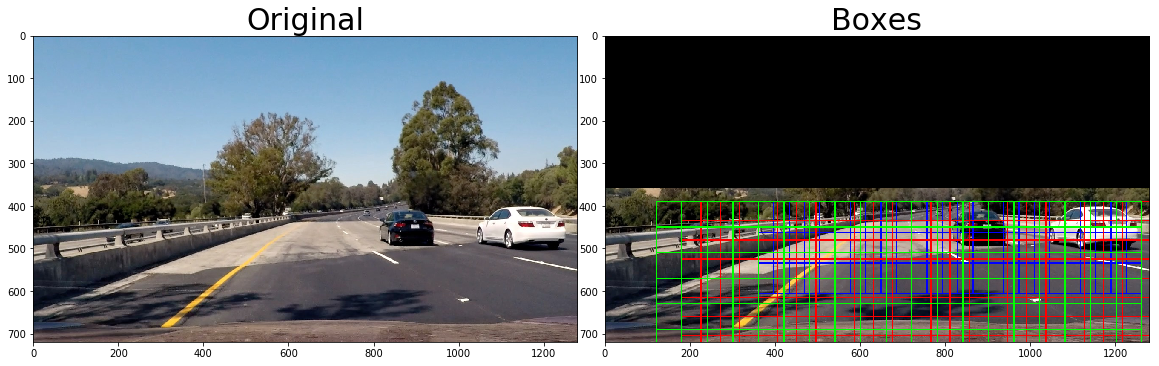

In [235]:
plot_2images(img,img_copy, "Original", "Boxes")

## object detection

In [236]:
def f_detection(img, boxes, m=1188, flag=False):
    img_detection=img.copy()
    detections=[]
    for box in boxes:

        img_box=select_box(img_detection, box)
        features=preprocess(img_box, scaler, m)
        p=clf.predict(features)

        if p == 1:
            detections.append(box)
    if flag:
        for d in detections:
            bottom_left=d[0]
            upper_right=d[1]
            z=cv2.rectangle(img_detection,bottom_left,upper_right,(0,0,255), 2)
        return img_detection, detections
    return detections

In [237]:
img_detection, detections=f_detection(img,boxes, flag=True)

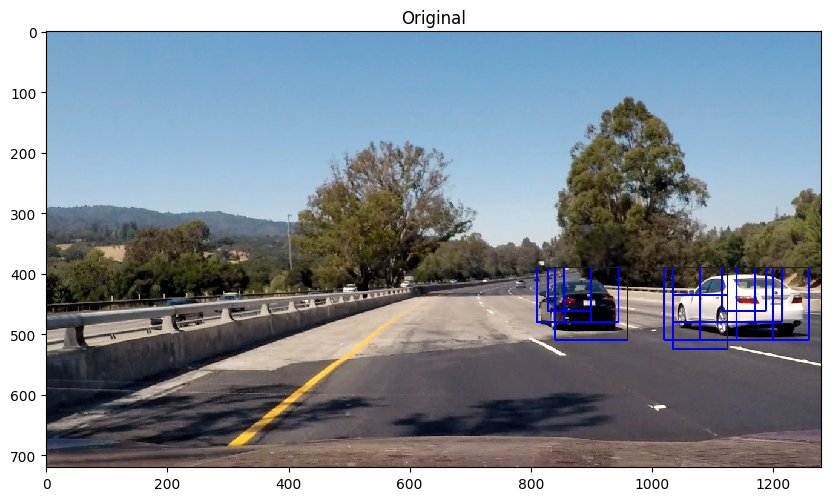

In [238]:
plot_image(img_detection)

In [239]:
def add_heat(detections, t=1):
    heatmap = np.zeros_like(img[:,:,0])
    for box in detections:
        xb, yb = box[0]
        xu, yu = box[1]
        ## ((x1, y1), (x2, y2))
        heatmap[yu:yb, xb:xu] += 1
    # Return updated heatmap
    heatmap[heatmap <= t] = 0
    return heatmap

In [240]:
def compute_labels(heatmap, flag=False):
    labels = label(heatmap)
    if flag:
        plot_image(labels[0], cmap='gray')
        
    return labels

In [241]:
heatmap=add_heat(detections)

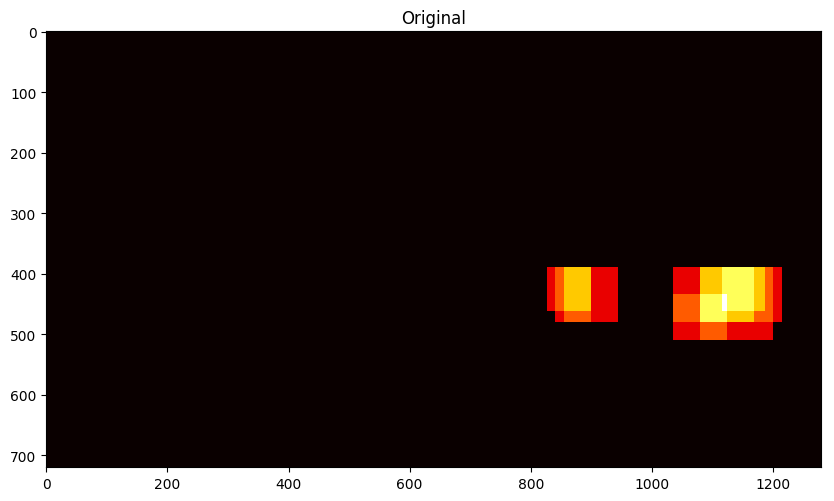

In [242]:
plot_image(heatmap, cmap="hot")

In [243]:
labels=compute_labels(heatmap)

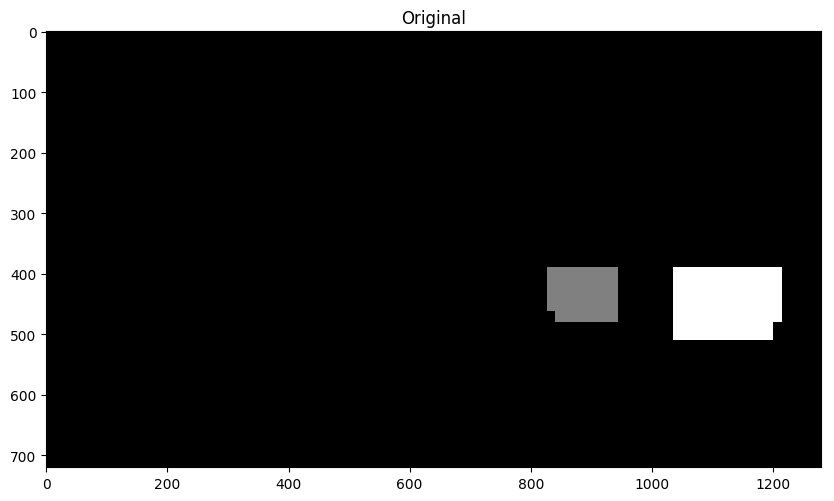

In [244]:
plot_image(labels[0], cmap="gray")

In [436]:
def compute_boxes(labels):
    boxes=[]
    n=labels[1]
    for i in range(1, n+1):
        nonzero = (labels[0] == i).nonzero()
        nonzero_y = np.array(nonzero[0])
        nonzero_x = np.array(nonzero[1])
        
        bottom_left = (np.min(nonzero_x), np.min(nonzero_y))
        upper_right = (np.max(nonzero_x), np.max(nonzero_y))
        box = (bottom_left, upper_right)
        boxes.append(box)
    return boxes

In [437]:
def draw_boxes(img, boxes):
    for box in boxes:
        cv2.rectangle(img, box[0], box[1], (0,0,255), 6)
    return img

In [438]:
boxes=compute_boxes(labels)

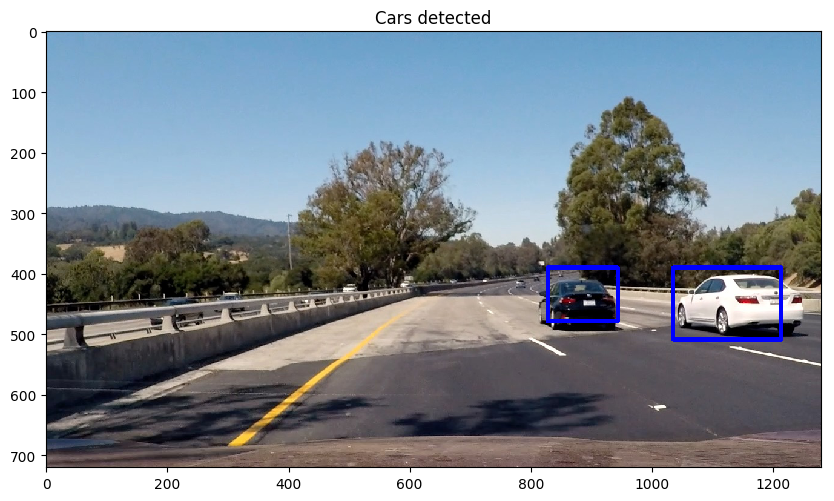

In [439]:
draw_img = draw_boxes(np.copy(img), boxes)
# Display the image
plot_image(draw_img, "Cars detected")

In [329]:
def pipeline(img, flag=False):
    image=img.copy()
    windows=collect_windows(image)
    detections=f_detection(image,windows)
    heatmap=add_heat(detections)
    labels=compute_labels(heatmap)
    boxes=compute_boxes(labels)
    
    if flag:
        draw_img = draw_boxes(image, boxes)
        return draw_img, boxes
    
    return boxes

In [330]:
files=os.listdir("./test_images/")

In [331]:
files

['test2.jpg', 'test5.jpg', 'test6.jpg', 'test1.jpg', 'test4.jpg', 'test3.jpg']

In [332]:
def plot_N_images(files, flag=False):

    fig, axs = plt.subplots(len(files), 2, figsize=(20,20))
    fig.subplots_adjust(hspace = .2, wspace=.05)
    for f in range(len(files)):
        file = files[f]
        image = mpimg.imread("./test_images/" + file)
        img=image.copy()
        draw_img, boxes=pipeline(image, True)
        
        axs[f, 0].imshow(image)
        axs[f,1].imshow(draw_img)
        if flag:
            mpimg.imsave("output_images/" + file, result, format="jpg")

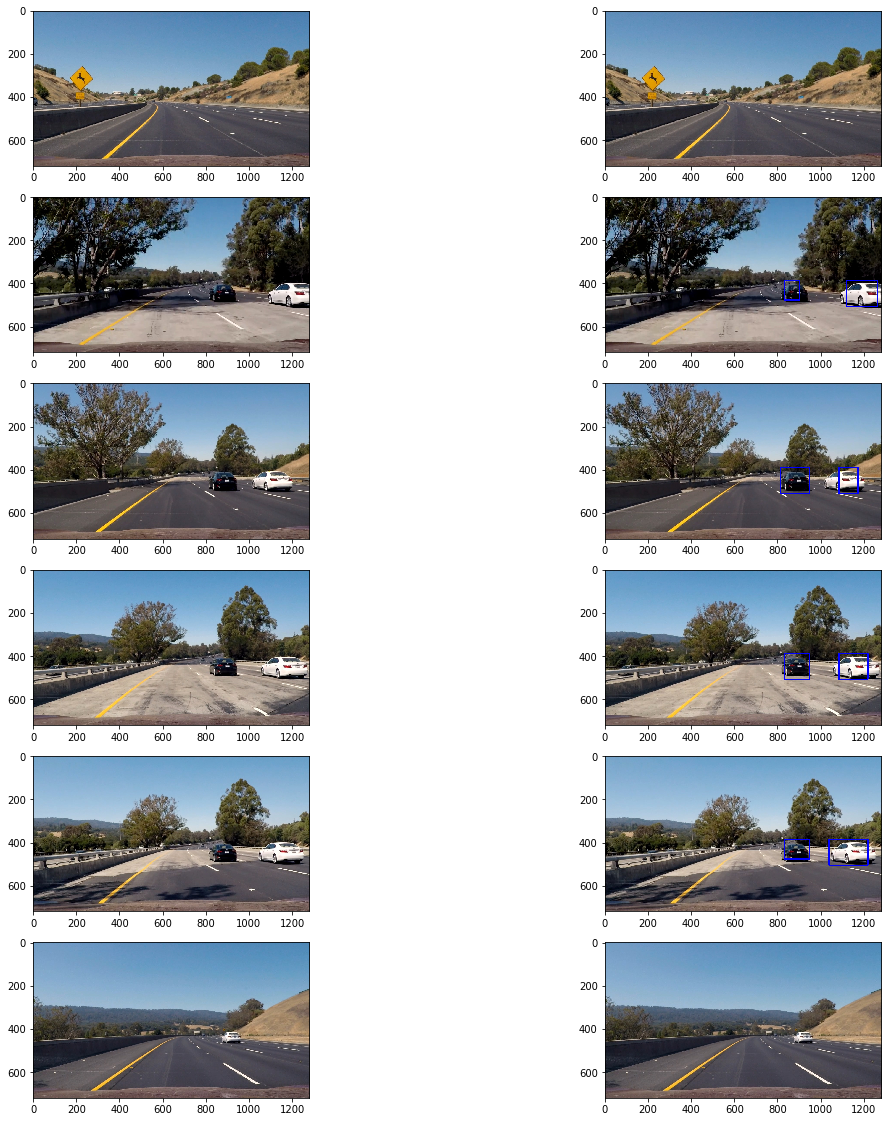

In [333]:
plot_N_images(files)

In [489]:
class Detector:
    
    def __init__(self):
        self.stack_boxes=[]
        self.boxes=[]
        self.n_cars=0
        self.dist=[0]
        
    def get_boxes(self):
        return self.boxes
        
    def distance(self, boxes):
        if len(boxes) == self.n_cars:
            for b in range(len(boxes)):
                x=np.array(boxes[b])
                y=np.array(self.boxes[b])
                self.dist=[]
                if self.boxes is not []:
                    dist = abs(x - y) / y
                    dist = sum(dist) / len(dist)
                    self.dist.append(dist)
                else:
                    self.dist = [0]
        else:
            self.n_cars=len(boxes)
            self.stack_boxes=[]
            self.boxes=[]
                
    def update(self, boxes, t=20, dist=0.25):
        if len(self.stack_boxes) > t:
            self.stack_boxes.pop(0)
        self.distance(boxes)
        ##print(np.mean(self.dist))
        if  np.mean(self.dist) < 0.25:
            self.stack_boxes.append(boxes)
            temp = np.mean(np.array(self.stack_boxes), axis=0)
            temp=temp.astype(int)
            
            self.boxes=[ ( tuple(b[0]), tuple(b[1]) ) for b in temp ]

In [490]:
detector=Detector()

def process_image(image):
    new_image = image.copy()
    boxes=pipeline(new_image)
    
    detector.update(boxes)
    average_boxes=detector.get_boxes()
    
    res = draw_boxes(image, boxes)
    return res

In [491]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [492]:
video_output1 = 'test_video_output.mp4'
video_input1 = VideoFileClip('./test_video.mp4')
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

0.0
[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4



  3%|▎         | 1/39 [00:05<03:16,  5.18s/it]

0.0



  5%|▌         | 2/39 [00:10<03:12,  5.21s/it]

0.0



  8%|▊         | 3/39 [00:15<03:06,  5.18s/it]

0.0



 10%|█         | 4/39 [00:22<03:15,  5.58s/it]

0.00641573994867



 13%|█▎        | 5/39 [00:27<03:07,  5.52s/it]

0.00212044105174



 15%|█▌        | 6/39 [00:37<03:44,  6.79s/it]

0.00488945578231



 18%|█▊        | 7/39 [00:42<03:27,  6.49s/it]

0.00381033022862



 21%|██        | 8/39 [00:51<03:35,  6.96s/it]

0.00316722972973



 23%|██▎       | 9/39 [01:09<05:13, 10.46s/it]

0.00358347386172



 26%|██▌       | 10/39 [01:23<05:28, 11.33s/it]

0.00316722972973



 28%|██▊       | 11/39 [01:27<04:22,  9.38s/it]

0.00274957698816



 31%|███       | 12/39 [01:32<03:34,  7.96s/it]

0.00254022015241



 33%|███▎      | 13/39 [01:38<03:08,  7.26s/it]

0.00212044105174



 36%|███▌      | 14/39 [01:43<02:46,  6.64s/it]

0.00742154368109



 38%|███▊      | 15/39 [01:48<02:31,  6.29s/it]

0.00698560541914



 41%|████      | 16/39 [01:57<02:43,  7.09s/it]

0.00633445945946



 44%|████▎     | 17/39 [02:04<02:33,  6.99s/it]

0.0153878583474



 46%|████▌     | 18/39 [02:09<02:16,  6.50s/it]

0.00189075630252



 49%|████▊     | 19/39 [02:16<02:09,  6.45s/it]

0.0016792611251



 51%|█████▏    | 20/39 [02:26<02:26,  7.72s/it]

0.0016792611251



 54%|█████▍    | 21/39 [02:32<02:05,  6.99s/it]

0.0016792611251



 56%|█████▋    | 22/39 [02:46<02:34,  9.07s/it]

0.00146812080537



 59%|█████▉    | 23/39 [02:56<02:32,  9.56s/it]

0.00461409395973



 62%|██████▏   | 24/39 [03:06<02:25,  9.67s/it]

0.00418760469012



 64%|██████▍   | 25/39 [03:15<02:10,  9.30s/it]

0.000627090301003



 67%|██████▋   | 26/39 [03:20<01:45,  8.13s/it]

0.000627090301003



 69%|██████▉   | 27/39 [03:26<01:28,  7.35s/it]

0.00333889816361



 72%|███████▏  | 28/39 [03:31<01:15,  6.91s/it]

0.0125104253545



 74%|███████▍  | 29/39 [03:39<01:10,  7.02s/it]

0.0120732722731



 77%|███████▋  | 30/39 [03:45<01:00,  6.72s/it]

0.00207641196013



 79%|███████▉  | 31/39 [03:52<00:55,  6.98s/it]

0.00145107794362



 82%|████████▏ | 32/39 [03:59<00:47,  6.79s/it]

0.0139738698532



 85%|████████▍ | 33/39 [04:08<00:45,  7.63s/it]

0.0111928879396



 87%|████████▋ | 34/39 [04:20<00:43,  8.72s/it]

0.01007135563



 90%|████████▉ | 35/39 [04:29<00:35,  8.96s/it]

0.00957175555318



 92%|█████████▏| 36/39 [04:40<00:28,  9.54s/it]

0.00907440944727



 95%|█████████▍| 37/39 [04:45<00:16,  8.31s/it]

0.130062016173



 97%|█████████▋| 38/39 [04:51<00:07,  7.42s/it]

0.0141377921289


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

CPU times: user 4min 20s, sys: 460 ms, total: 4min 20s
Wall time: 5min 3s


In [493]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))